# Symmetric and asymmetric up/downconversion

QICK can be used with or without analog mixers, but either way the readout scheme is typically what I will call symmetric: you either have mixers on both the DAC and ADC, or neither. The first QICK paper https://arxiv.org/abs/2110.00557 described mixers on both sides, the second QICK paper https://arxiv.org/abs/2311.17171 described mixer-free readout.

An asymmetric scheme is also possible, where you do pure digital upconversion and synthesis on the DAC side, but on the ADC side you do analog downconversion followed by ADC sampling and digital downconversion. (Or you could do the opposite?)

This demo is in response to https://github.com/openquantumhardware/qick/issues/236, though other groups have tried this idea as well.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### setup
I'm using a Hittite HMC-T2220 RF generator, which has an internal reference and outputs a 10 MHz reference. Its output frequency is settable in 1 Hz steps.

The QICK is locked to the 10 MHz reference and is accessed over Pyro - it's running the 00_nameserver and 01_server notebooks, the 01_server notebook is modified as follows:
```
from qick.pyro import start_server
# start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick")
start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick", external_clk=True)
```

Nothing in this demo really requires Pyro; it was just easier to control the RF generator from my PC.

For the first section (regular loopback), the DAC and ADC are both connected to 5-6 GHz baluns. (The RF generator is not doing anything at this point, except providing the frequency reference.) In a serious measurement you would optimize your SNR by putting a bandpass filter on the ADC, ideally one that (unlike the baluns, which are pretty broadband) rejects all Nyquist images of your signal tone.

In [2]:
# connect to the RF source, turn it off for now
import serial
ser = serial.Serial(port="/dev/ttyACM0",baudrate=115200)
ser.write("*IDN?\r".encode())
print(ser.read_until('\r\n'.encode()))
ser.write("outp off\r".encode());


b'Hittite,HMC-T2220,000342,2.5 5.1\r\n'


In [3]:
from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="pynq216.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)

# # if not using pyro:
# # Load bitstream, enable external clock
# # (don't forget to reload with external clock disabled when you no longer want it)
# soc = QickSoc(external_clk=True)
# soccfg = soc
# print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_186aa4dcbe334c71b602f1be1b9021ef@131.225.82.185:34437

QICK configuration:

	Board: ZCU216

	Software version: 0.2.234
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, bl

In [4]:
GEN_CH = 6
RO_CH = 1

### frequency matching

In a symmetric readout, you need to match the frequencies used in the generator and readout. This is normally guaranteed by specifying both the generator and readout channels when setting frequencies, as explained in the 00 demo under "How to ensure frequency matching." As long as you specify those channel numbers, the QICK library rounds your frequencies to the least common multiple of the channels' step sizes. If you have analog mixers, there's no need to match the LO frequency to anything since you just add it at upconversion and subtract it at downconversion.

In an asymmetric readout, you need to match the generator's upconversion frequency to the sum of the LO and the readout's downconversion frequency. In this demo we know the RF source's frequency step size, and we'll guarantee frequency matching by using the least common multiple of all three step sizes. Note that this might possibly be overkill (it's a sufficient condition, but might not be necessary), but it's easy to think about.

For this RF generator, this gives you a pretty big step size: 66 kHz, vs. 8 Hz when you just have the generator and readout. Anyway, if we round our frequencies to this step size we can guarantee that the three frequencies will end up being matched.

In [35]:
# make a fake config dict for the RF source's frequency stepping
# it has 1 Hz steps, that's like dividing the refclk (245.76 MHz) by 245.76e6
cfg_lo = {'fdds_div': int(soccfg['refclk_freq']*1e6),
    'b_dds': 0,
    'fs_mult': 1}

print("fstep for generator and readout:", soccfg.calc_fstep([soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH]]))
fstep = soccfg.calc_fstep([soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH], cfg_lo])
print("fstep for generator, readout, and LO:", fstep)

fstep for generator and readout: 8.0108642578125e-06
fstep for generator, readout, and LO: 0.065625


In [26]:
# we want RF at ~5.5 GHz, IF at ~1 GHz, and LO at the difference
RF_FREQ = soccfg.roundfreq(5500, [soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH], cfg_lo])
IF_FREQ = soccfg.roundfreq(1000, [soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH], cfg_lo])
LO_FREQ = RF_FREQ - IF_FREQ
print("rounded freqs:", RF_FREQ, IF_FREQ, LO_FREQ)

rounded freqs: 5500.03125 999.9937500000001 4500.0375


### loopback program
This is a simplified version of the loopback program in the 00 demo, with added parameters to allow for setting different upconversion and downconversion frequencies, changing the NQZ setting of the generator, and changing the generator mode to periodic (CW) for checking power levels with a spectrum analyzer.

In [7]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=GEN_CH, nqz=cfg["nqz"])
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        readoutlen = self.us2cycles(cfg["readout_length"], ro_ch=RO_CH)
        self.declare_readout(ch=RO_CH, length=readoutlen, freq=self.cfg["ro_freq"], gen_ch=GEN_CH)

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=GEN_CH, ro_ch=RO_CH)
        phase = self.deg2reg(cfg["res_phase"], gen_ch=GEN_CH)
        gain = cfg["pulse_gain"]
        pulselen = self.us2cycles(cfg["length"], gen_ch=GEN_CH)
        self.set_pulse_registers(ch=GEN_CH, freq=freq, phase=phase, gain=gain, style="const", length=pulselen,
                                mode=cfg["mode"])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=GEN_CH, 
                     adcs=[RO_CH],
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

  0%|          | 0/100 [00:00<?, ?it/s]

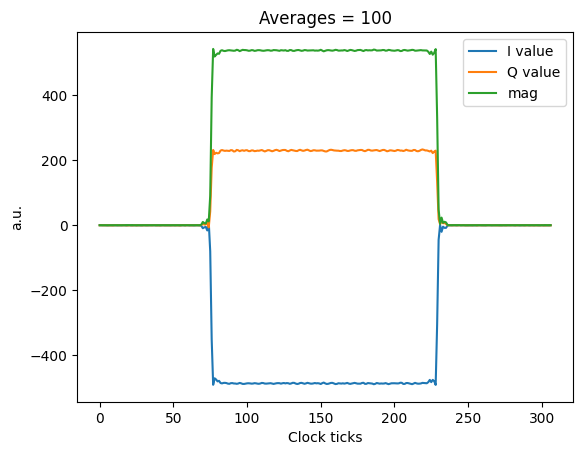

In [8]:
# note the long relax_delay, for a shot time of 0.1 ms
# this will let us check for phase coherence over time with a multi-rep measurement
config={"reps":1, # --Fixed
        "relax_delay":100.0, # --us
        "res_phase":0, # --degrees
        "length":0.5, # [us]
        "readout_length":1.0, # [us]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": RF_FREQ, # [MHz]
        "ro_freq": RF_FREQ, # [MHz]
        "nqz": 2,
        "adc_trig_offset": 0.2, # [us]
        "soft_avgs":100,
        "mode": "oneshot"
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

  0%|          | 0/10000 [00:00<?, ?it/s]

averaged IQ: ([array([-244.26161042])], [array([115.59785049])])


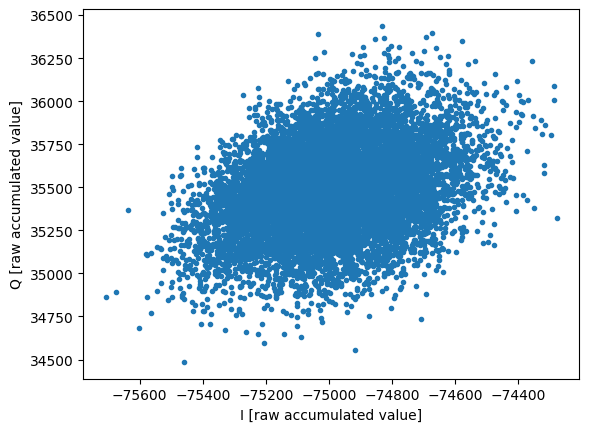

In [9]:
# do a multi-rep measurement and plot the shot-by-shot IQ values, to show stability
# some transient phase drift is expected, the transient should settle down with time
# but if the phase keeps rotating forever by a constant rate, that indicates a frequency mismatch
config['reps'] = 10000
config['soft_avgs'] = 1

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

### with analog downconversion
Connect a Marki MM1-0212H mixer as follows:
* RF: DAC (through 5-6 GHz balun)
* LO: RF generator
* IF: ADC (through Mini-Circuits VLFX-1300+ low-pass filter and 0-1 GHz balun)

In [16]:
# turn on the RF generator
ser.write("freq {0}Hz;pow 15.0dBm;outp on\r".format(int(LO_FREQ*1e6)).encode());

  0%|          | 0/100 [00:00<?, ?it/s]

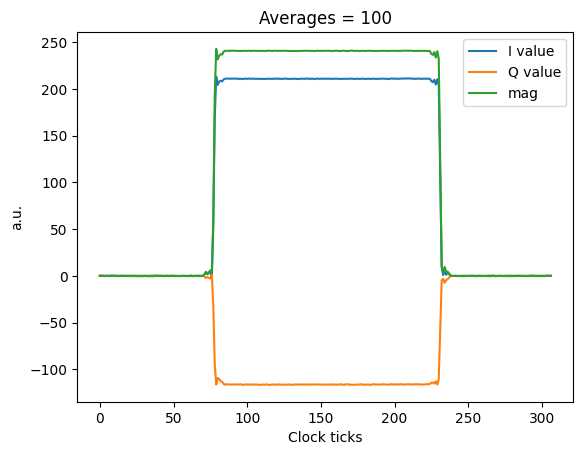

In [25]:
# note the long relax_delay, for a shot time of 0.1 ms
# this will let us check for phase coherence over time with a multi-rep measurement
config={"reps":1, # --Fixed
        "relax_delay":100.0, # --us
        "res_phase":0, # --degrees
        "length":0.5, # [us]
        "readout_length":1.0, # [us]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": RF_FREQ, # [MHz]
        "ro_freq": IF_FREQ, # [MHz]
        "nqz": 2,
        "adc_trig_offset": 0.2, # [us]
        "soft_avgs":100,
        "mode": "oneshot"
#         "mode": "periodic"
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

Let's do a multi-rep measurement and plot the shot-by-shot IQ values.

There's more phase noise than in the symmetric case - maybe this is from the RF generator. But a phase vs. shot plot confirms that this is really random noise, centered at a constant value.

  0%|          | 0/100000 [00:00<?, ?it/s]

averaged IQ: ([array([105.54015274])], [array([-54.69293176])])


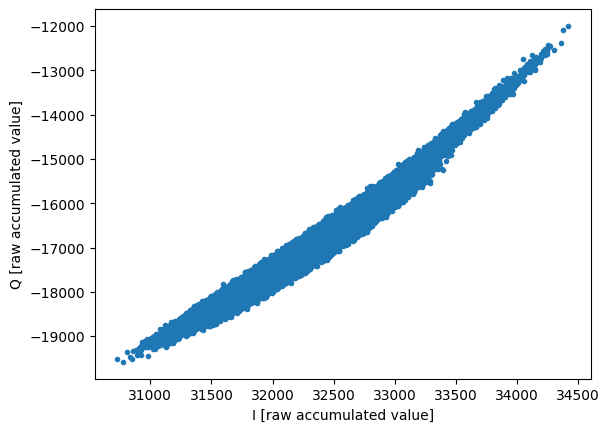

In [36]:
config['reps'] = 100000
config['soft_avgs'] = 1

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

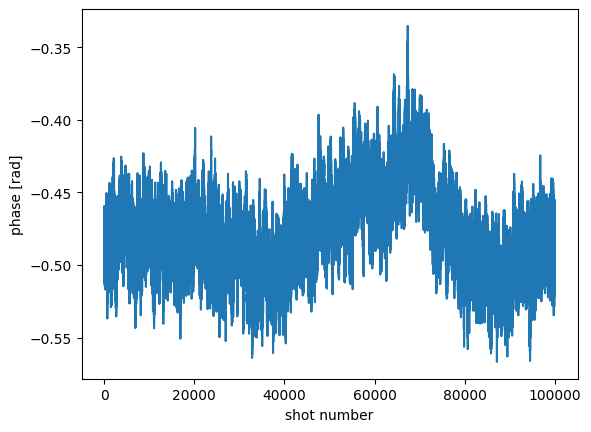

In [37]:
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
plt.ylabel("phase [rad]")
plt.xlabel("shot number");

Let's intentionally detune the LO by 1 Hz. Now we see the measured phase rotate smoothly.

In [38]:
ser.write("freq {0}Hz\r".format(int(LO_FREQ*1e6 + 1)).encode());

  0%|          | 0/100000 [00:00<?, ?it/s]

averaged IQ: ([array([1.32040987])], [array([-0.96743889])])


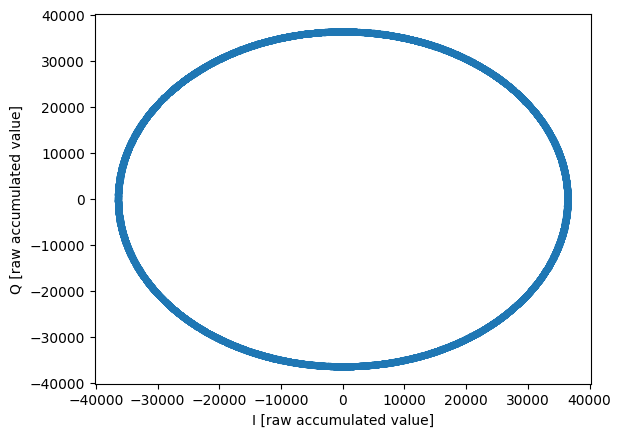

In [39]:
config['reps'] = 100000
config['soft_avgs'] = 1

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

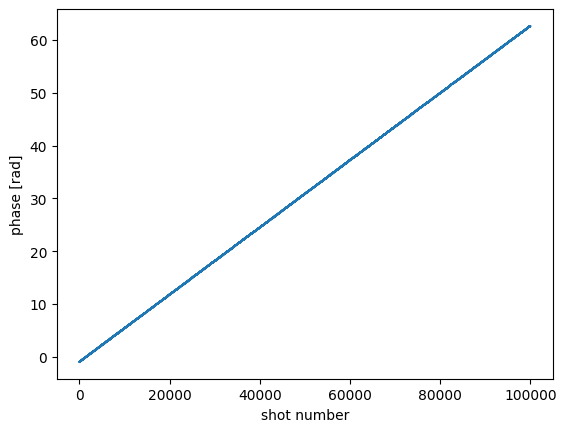

In [40]:
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
plt.ylabel("phase [rad]")
plt.xlabel("shot number");

If we change units, we can see that the phase is rotating by 1 cycle/sec, as you'd expect.

Note that the time axis is not very precise here: the shot-to-shot time interval is really the sum of the trigger delay, the readout window length, and the relax_delay. But just using the relax_delay is close enough for teaching purposes.

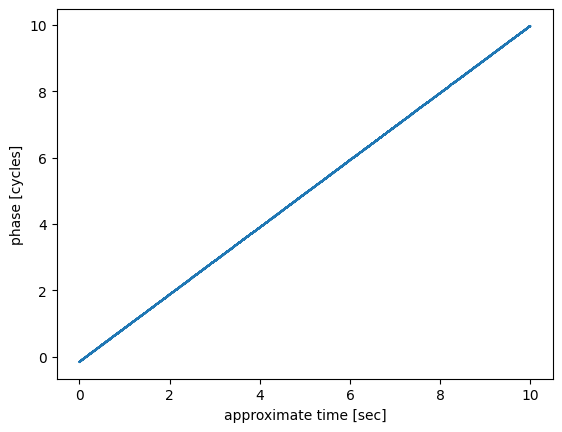

In [43]:
t = np.arange(len(phases))*config['relax_delay']*1e-6
plt.plot(t, phases/(2*np.pi))
plt.ylabel("phase [cycles]")
plt.xlabel("approximate time [sec]");

### debugging and scratchwork (ignore)

In [ ]:
# do a multi-rep measurement and plot the shot-by-shot IQ values, to show stability
# some transient phase drift is expected, particularly at high IF
# the transient should settle down with time, and we've never seen it exceed 100 mr
# but if the phase keeps rotating forever by a constant rate, that indicates a frequency mismatch
config['reps'] = 10000
config['soft_avgs'] = 1
config['relax_delay'] = 1000.0

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

In [ ]:
# 4423.68 MHz - 1 Hz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

In [ ]:
# 4423.68 MHz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

In [ ]:
# 4423.68 MHz + 1 Hz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

In [ ]:
# 4423.68 MHz + 0 Hz
iq_list = prog.acquire(soc, progress=True)
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

In [ ]:
mismatch = np.array([-16.886099707850352,
-6.868455713753351,
3.135273761570384])

In [ ]:
mismatch - 10*np.arange(3)

In [ ]:
print(soccfg.roundfreq(4500, soccfg['readouts'][RO_CH], soccfg['gens'][GEN_CH]))

In [ ]:
fstep = soccfg.calc_fstep(soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH])
print(fstep * 2**24 * 41)
print(fstep * 2**24 * 8)
print(fstep * 2**24 * 33)


In [ ]:
fstep = soccfg.calc_fstep(soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH])
print(fstep * 2**13)

In [ ]:
class CWProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=GEN_CH, nqz=cfg["nqz"])
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        readoutlen = self.us2cycles(cfg["readout_length"], ro_ch=RO_CH)
        self.declare_readout(ch=RO_CH, length=readoutlen, freq=self.cfg["ro_freq"], gen_ch=GEN_CH)

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=GEN_CH, ro_ch=RO_CH)
        gain = cfg["pulse_gain"]
        self.set_pulse_registers(ch=GEN_CH, freq=freq, phase=0, gain=gain, style="const", length=10,
                                mode="periodic")

        self.pulse(ch=GEN_CH, t=0)
        
        self.synci(1000)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[RO_CH],
             pins=[0], 
             adc_trig_offset=0)
        self.waiti(0,0)
        self.synci(self.us2cycles(self.cfg["relax_delay"]))
        
config={"reps":200000, # --Fixed
        "relax_delay":5.0, # --us
        "readout_length":2.0, # [us]
        "pulse_gain": 30000, # [DAC units]
        "pulse_freq": 5510.4, # [MHz]
        "ro_freq": 1075.2, # [MHz]
        "nqz": 2,
        "soft_avgs":1
       }

prog =CWProgram(soccfg, config)
t0 = time.time()
iq_list = prog.acquire(soc, progress=False)
t1 = time.time()
print("runtime", t1-t0)
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))/(2*np.pi) # units of cycles

t = np.arange(len(phases))*config['relax_delay']*1e-6
plt.plot(t, phases, '.')
a = np.vstack([t, np.ones_like(phases)]).T
p = np.linalg.lstsq(a, phases, rcond=None)[0]
plt.plot(t, t*p[0] + p[1])
plt.ylabel("phase [cycles]")
plt.xlabel("time [s]")

print("slope", p[0])

In [ ]:
print(soccfg.roundfreq(5406.72, soccfg['readouts'][RO_CH], soccfg['gens'][GEN_CH]))
print(soccfg.roundfreq(983.04, soccfg['readouts'][RO_CH], soccfg['gens'][GEN_CH]))


In [ ]:
print(soccfg.freq2int(5406.72, soccfg['gens'][GEN_CH], soccfg['readouts'][RO_CH]))

In [ ]:
config={"reps":10000, # --Fixed
        "relax_delay":1.0, # --us
        "readout_length":0.5, # [us]
        "pulse_gain": 30000, # [DAC units]
        "pulse_freq": 5406.72, # [MHz]
        "ro_freq": 983.04, # [MHz]
        "nqz": 2,
        "soft_avgs":1
       }

prog =CWProgram(soccfg, config)


dfs = np.linspace(-4e5,4e5,101, dtype=int)

print(dfs)
slopes = []

t = np.arange(config['reps'])*config['relax_delay']*1e-6

from tqdm.auto import tqdm
for i, df in enumerate(tqdm(dfs)):
    ser.write("freq {0}Hz\r".format(4423680000+df).encode())
    
    iq_list = prog.acquire(soc, progress=False)
    phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))/(2*np.pi) # units of cycles
    a = np.vstack([t, np.ones_like(phases)]).T
    p = np.linalg.lstsq(a, phases, rcond=None)[0]
    slopes.append(p[0])
slopes = np.array(slopes)

In [ ]:
print(phases[:10])

In [ ]:
plt.plot(dfs, slopes-dfs, '.')


In [ ]:
plt.plot(dfs, slopes-dfs, '.')

In [ ]:
plt.plot(dfs, slopes-dfs, '.')

In [ ]:
df = np.arange(-100,100,10, dtype=int)
print(df)

In [ ]:
[-10001.15198268696,
 -0.6839915723720261,
 9999.777012049868]

In [ ]:
print(time.time())
iq_list = prog.run_rounds(soc, progress=False)
print(time.time())

In [ ]:
import serial
ser = serial.Serial(port="/dev/ttyACM0",baudrate=115200)
ser.write("*IDN?\r".encode())
print(ser.read_until('\r\n'.encode()))
# # ser.read()

# ser.write("freq 16.384GHz;pow -1.2dBm;outp on\r".encode())
# # ser.read_until('\r\n'.encode())

# # "freq 16.384GHz;pow 17.2dBm;outp on"
ser.write("freq 4423680000Hz\r".encode())
# ser.read_until('\r\n'.encode())

In [ ]:
ser.write("freq 4423680000Hz\r".encode())
# ser.read_until('\r\n'.encode())